In [2]:
from dotenv import get_variable
from io import BytesIO
from requests import get
from zipfile import ZipFile
from tinkoff.invest.sandbox.client import SandboxClient
from tinkoff.invest.constants import INVEST_GRPC_API_SANDBOX
from tinkoff.invest.schemas import InstrumentStatus
import polars as  pl
from time import sleep
import matplotlib.pyplot as plt

TOKEN = get_variable('.env', 'TOKEN')

По тикерам данные не достать, но можно достать по figi (это уникальный идентификатор бумаги для всех бирж), а figi можно достать по тикеру

In [3]:
def get_all_figi_by_ticker(ticker):
    with SandboxClient(TOKEN, target=INVEST_GRPC_API_SANDBOX) as client:
        return [i.figi for i in client.instruments.shares(instrument_status=InstrumentStatus.INSTRUMENT_STATUS_ALL).instruments if i.ticker == ticker]

In [76]:
def download_by_figi(figi, name, start_year, end_year=None):
    if end_year is None:
        end_year = start_year
    instrument_dfs = []
    for year in range(start_year, end_year + 1):
        while True:
            r = get('https://invest-public-api.tinkoff.ru/history-data', params={'figi': figi, 'year': year}, headers={'Authorization': f'Bearer {TOKEN}'})
            if r.status_code == 429: # timeout
                print('[timeout] ', end='')
                sleep(5)
                continue
            if r.status_code == 404: # not found
                print(f'{name} ({figi}) not found for year {year}')
                return None
            if r.status_code != 200: # some other error
                print(f'failed with error {r.status_code}')
                return None
            with ZipFile(BytesIO(r.content)) as z:
                for file in z.namelist():
                    instrument_dfs.append(pl.read_csv(z.open(file).read(), separator=';', new_columns=['utc', 'open', 'close', 'high', 'low', 'volume'], columns=[1, 2, 3, 4, 5, 6], try_parse_dates=True, infer_schema_length=None).select(pl.col('utc').cast(pl.Datetime), pl.exclude('utc', 'volume').cast(pl.Float64), 'volume'))
            break
        print(year, '...', sep='', end=' ')
    return pl.concat(instrument_dfs).unique().sort(by='utc')

### Яндекс

In [4]:
get_all_figi_by_ticker('YNDX')

['TCSS09805522', 'TCS109805522', 'BBG006L8G4H1']

In [98]:
YNDX_df = download_by_figi('BBG006L8G4H1', 'Yandex', 2018, 2024)

2018... 2019... 2020... 2021... 2022... 2023... 2024... 

In [99]:
get_all_figi_by_ticker('YDEX')

['TCS00A107T19']

In [100]:
YDEX_df = download_by_figi('TCS00A107T19', 'Yandex', 2024)

2024... 

Склеим данные по двум тикерам:

In [101]:
yandex_data = pl.concat([YNDX_df, YDEX_df]).unique().sort(by='utc')

In [9]:
yandex_data

utc,Yandex open,Yandex close,Yandex high,Yandex low,Yandex volume
"datetime[μs, UTC]",f64,f64,f64,f64,i64
2018-03-07 18:40:00 UTC,2375.0,2375.0,2375.0,2375.0,80
2018-03-07 18:41:00 UTC,2377.5,2377.5,2377.5,2377.5,39
2018-03-07 18:42:00 UTC,2377.5,2377.5,2377.5,2377.5,19
2018-03-07 18:43:00 UTC,2378.0,2378.0,2378.0,2378.0,51
2018-03-07 18:44:00 UTC,2379.0,2379.0,2379.0,2379.0,5
…,…,…,…,…,…
2024-12-06 20:45:00 UTC,3375.0,3375.0,3375.5,3375.0,249
2024-12-06 20:46:00 UTC,3375.0,3373.5,3375.0,3372.0,185
2024-12-06 20:47:00 UTC,3371.5,3373.0,3373.0,3370.0,264


In [32]:
# Функция для увеличения интервала свечей для Polars

def merge_candles(df, freq):
    # Берем первое значение колонок, помеченных как open, последнее для high, максимальное для high и минимальное для low
    return df.group_by_dynamic('utc', every=freq).agg({'open': pl.first, 'close': pl.last, 'high': pl.max, 'low': pl.min, 'volume': pl.sum}[col.split()[-1]](col) for col in df.columns[1:])

In [103]:
# Превращаем минутные свечки в десятиминутные 
yandex_data.write_csv("Yandex_1_min.csv")
yandex_data_10min = merge_candles(yandex_data, '10m')
yandex_data_10min.write_csv("T_yandex_10min.csv")
yandex_data_10min

utc,open,close,high,low,volume
datetime[μs],f64,f64,f64,f64,i64
2018-03-07 18:40:00,2375.0,2379.5,2379.5,2375.0,231
2018-03-07 18:50:00,2380.0,2385.0,2385.0,2380.0,514
2018-03-07 19:00:00,2385.5,2388.0,2388.0,2384.0,226
2018-03-07 19:10:00,2388.0,2389.5,2389.5,2387.0,207
2018-03-07 19:20:00,2386.5,2386.0,2389.0,2386.0,25
…,…,…,…,…,…
2024-12-31 20:00:00,3990.5,3995.0,3999.0,3990.0,32
2024-12-31 20:10:00,3995.0,3998.5,3998.5,3995.0,19
2024-12-31 20:20:00,3995.5,4000.0,4000.0,3995.5,56


Посмотрим на временные промежутки, в которые были торги

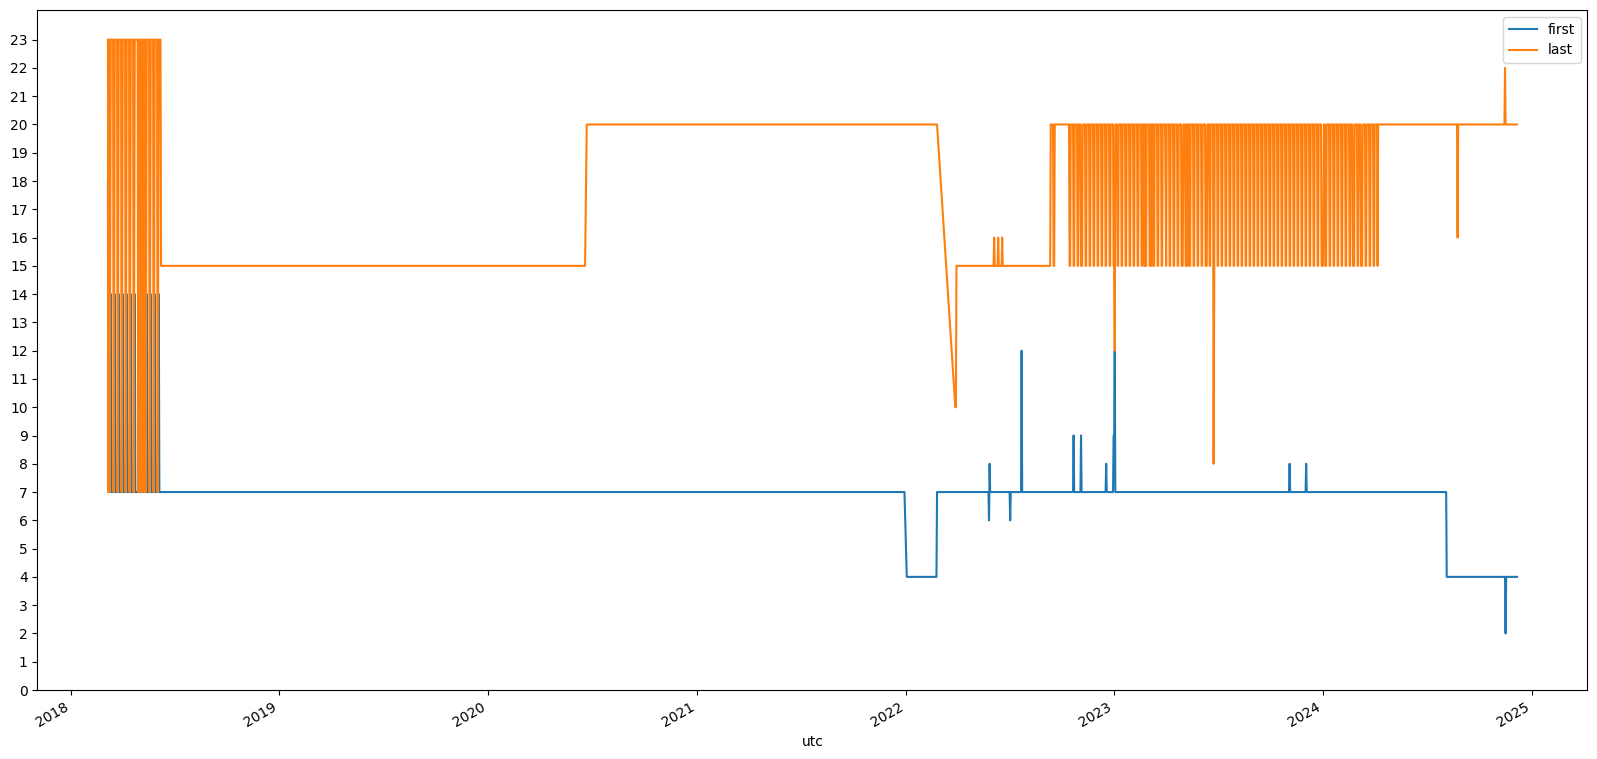

In [12]:
yandex_data_10min.group_by_dynamic('utc', every='1d').agg(pl.col('utc').dt.hour().min().alias('first'), pl.col('utc').dt.hour().max().alias('last')).to_pandas().set_index('utc').plot(figsize=(20, 10))

plt.yticks(range(24))
plt.show()

Посмотрим, появились данные по выходным

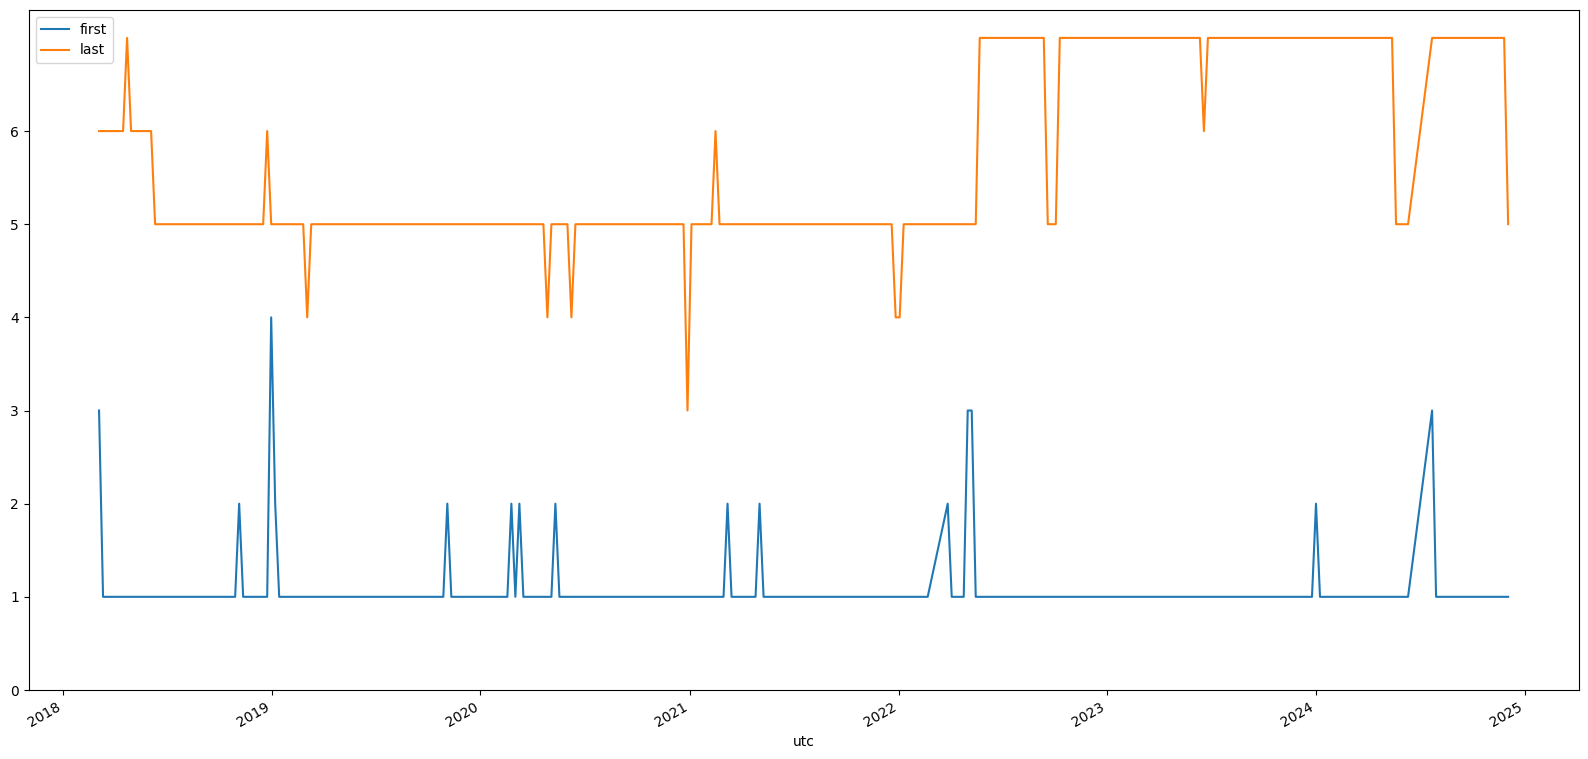

In [16]:
yandex_data_10min.group_by_dynamic('utc', every='1w').agg(pl.col('utc').dt.weekday().min().alias('first'), pl.col('utc').dt.weekday().max().alias('last')).to_pandas().set_index('utc').plot(figsize=(20, 10))

plt.yticks(range(7))
plt.show()

### Татнефть

In [7]:
get_all_figi_by_ticker('TATN')

['BBG004RVFFC0', 'TCS009033591']

In [28]:
TATN_df = download_by_figi('BBG004RVFFC0', 'Tatneft', 2018, 2024)

2018... 2019... 2020... 2021... 2022... 2023... 2024... 

In [29]:
TATN_df.write_csv("Tatneft_1_min.csv")
merge_candles(TATN_df, '10m').write_csv("Tatneft_10_min.csv")

### Сбербанк

In [16]:
get_all_figi_by_ticker('TATN')

['BBG004RVFFC0', 'TCS009033591']

In [26]:
SBER_df = download_by_figi('BBG004RVFFC0', 'Sber', 2018, 2024)

2018... 2019... 2020... 2021... 2022... 2023... 2024... 

In [27]:
SBER_df.write_csv("Sber_1_min.csv")
merge_candles(SBER_df, '10m').write_csv("Sber_10_min.csv")

### ФосАгро

In [30]:
get_all_figi_by_ticker('PHOR')

['BBG004S689R0', 'TCS00A0JRKT8']

In [55]:
PHOR_df = download_by_figi('BBG004S689R0', 'Phosagro', 2018, 2024)

2018... 2019... 2020... 2021... 2022... 2023... 2024... 

In [56]:
PHOR_df.write_csv("Phosagro_1_min.csv")
merge_candles(PHOR_df, '10m').write_csv("Phosagro_10_min.csv")

### MOEX

In [57]:
get_all_figi_by_ticker('MOEX')

['TCS10A0JR4A1', 'BBG004730JJ5']

In [59]:
MOEX_df = download_by_figi('BBG004730JJ5', 'Moex', 2018, 2024)

2018... 2019... 2020... 2021... 2022... 2023... 2024... 

In [60]:
MOEX_df.write_csv("Moex_1_min.csv")
merge_candles(MOEX_df, '10m').write_csv("Moex_10_min.csv")

### Норильский никель

In [61]:
get_all_figi_by_ticker('GMKN')

['TCS907288411', 'BBG004731489', 'TCS007288411']

In [63]:
GMKN_df = download_by_figi('BBG004731489', 'Nornickel', 2018, 2024)

2018... 2019... 2020... 2021... 2022... 2023... 2024... 

In [65]:
GMKN_df.write_csv("Nornickel_1_min.csv")
merge_candles(GMKN_df, '10m').write_csv("Nornickel_10_min.csv")

### Газпром

In [78]:
get_all_figi_by_ticker('GAZP')

['TCS907661625', 'TCSS07661625', 'TCS007661625', 'BBG004730RP0']

In [79]:
GAZP_df = download_by_figi('BBG004730RP0', 'Gazprom', 2018, 2024)

2018... 2019... 2020... 2021... 2022... 2023... 2024... 

In [80]:
GAZP_df.write_csv("Gazprom_1_min.csv")
merge_candles(GAZP_df, '10m').write_csv("Gazprom_10_min.csv")

### Новатэк

In [81]:
get_all_figi_by_ticker('NVTK')

['TCS00A0DKVS5', 'BBG00475KKY8']

In [82]:
NVTK_df = download_by_figi('BBG00475KKY8', 'Novatek', 2018, 2024)

2018... 2019... 2020... 2021... 2022... 2023... 2024... 

In [83]:
NVTK_df.write_csv("Novatek_1_min.csv")
merge_candles(NVTK_df, '10m').write_csv("Novatek_10_min.csv")

### Positive Technologies 🧘‍♀️🙏

In [84]:
get_all_figi_by_ticker('POSI')

['TCS10A103X66', 'TCS20A103X66', 'TCS00A103X66', 'TCS30A103X66']

In [90]:
POSI_df = download_by_figi('TCS00A103X66', 'PositiveTech', 2021, 2024)

2021... 2022... 2023... 2024... 

In [91]:
POSI_df.write_csv("Positive_1_min.csv")
merge_candles(POSI_df, '10m').write_csv("Positive_10_min.csv")